Уральсков Евгений ПИ18-2

Датасет: https://www.kaggle.com/austinreese/craigslist-carstrucks-data  
Данные о ценах на автомобили на вторичном рынке

Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

## Очистка данных

Загрузка и просмотр структуры данных

In [2]:
df = pd.read_csv('vehicles.csv')
print(f'Кол-во записей: {len(df)}')
print(f'Кол-во колонок: {len(df.columns)}')
df.head()

Кол-во записей: 423857
Кол-во колонок: 25


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7184791621,https://duluth.craigslist.org/ctd/d/duluth-200...,duluth / superior,https://duluth.craigslist.org,6995,2000.0,gmc,new sierra 1500,excellent,8 cylinders,...,4wd,NaN,NaN,red,https://images.craigslist.org/00n0n_f06ykBMcdh...,2000 *** GMC New Sierra 1500 Ext Cab 157.5 WB...,NaN,mn,46.8433,-92.2550
1,7184773187,https://duluth.craigslist.org/cto/d/saginaw-20...,duluth / superior,https://duluth.craigslist.org,8750,2013.0,hyundai,sonata,excellent,4 cylinders,...,fwd,NaN,NaN,grey,https://images.craigslist.org/00d0d_kgZ6xoeRw2...,For Sale: 2013 Hyundai Sonata GLS - $8750. O...,NaN,mn,46.9074,-92.4638
2,7193375964,https://newhaven.craigslist.org/cto/d/stratfor...,new haven,https://newhaven.craigslist.org,10900,2013.0,toyota,prius,good,4 cylinders,...,fwd,NaN,NaN,blue,https://images.craigslist.org/00d0d_3sHGxPbY2O...,2013 Prius V Model Two. One owner—must sell my...,NaN,ct,41.1770,-73.1336
3,7195108810,https://albuquerque.craigslist.org/cto/d/albuq...,albuquerque,https://albuquerque.craigslist.org,12500,2003.0,mitsubishi,lancer,good,4 cylinders,...,4wd,mid-size,sedan,grey,https://images.craigslist.org/00m0m_4a8Pb6JbMG...,"2003 Mitsubishi Lancer Evolution, silver. Abo...",NaN,nm,35.1868,-106.6650
4,7184712241,https://duluth.craigslist.org/ctd/d/rush-city-...,duluth / superior,https://duluth.craigslist.org,16995,2007.0,gmc,sierra classic 2500hd,good,8 cylinders,...,4wd,full-size,truck,white,https://images.craigslist.org/01414_g093aPtSMW...,"**Bad Credit, No Credit... No Problem!**2007 G...",NaN,mn,45.6836,-92.9648


Наименования колонок

In [3]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')

**id** - id объявления  
**url** - адрес объявления  
**region** - название региона продажи  
**region_url** - адрес страницы с объявлениями о продаже для данного региона  
**price** - цена  
**year** - год выпуска автомобиля  
**manufacturer** - марка автомобиля  
**model** - модель автомобиля  
**condition** - состояние автомобиля  
**cylinders** - количество цилиндров  
**fuel** - тип топлива  
**odometer** - пробег  
**title_status** - "статус" автомобиля (чистая, грязная, на запчасти и т.д.)  
**transmission** - тип трансмиссии (механика, автомат)  
**vin** - vin-номер, уникальный номер автомобиля  
**drive** - привод  
**size** - размер автомобиля  
**type** - тип кузова  
**paint_color** - цвет автомобиля  
**image_url** - ссылка на изображение  
**description** - описание  
**county** - страна продажи (всегда США)  
**state** - штат  
**lat, long** - координаты объявления  

Удаляем то что точно не понадобится

In [4]:
df = df[['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
        'transmission', 'drive', 'size', 'type', 'paint_color', 'description', 'state']]
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,description,state
0,7184791621,duluth / superior,6995,2000.0,gmc,new sierra 1500,excellent,8 cylinders,gas,167783.0,clean,automatic,4wd,NaN,NaN,red,2000 *** GMC New Sierra 1500 Ext Cab 157.5 WB...,mn
1,7184773187,duluth / superior,8750,2013.0,hyundai,sonata,excellent,4 cylinders,gas,90821.0,clean,automatic,fwd,NaN,NaN,grey,For Sale: 2013 Hyundai Sonata GLS - $8750. O...,mn
2,7193375964,new haven,10900,2013.0,toyota,prius,good,4 cylinders,hybrid,92800.0,clean,automatic,fwd,NaN,NaN,blue,2013 Prius V Model Two. One owner—must sell my...,ct
3,7195108810,albuquerque,12500,2003.0,mitsubishi,lancer,good,4 cylinders,gas,NaN,clean,manual,4wd,mid-size,sedan,grey,"2003 Mitsubishi Lancer Evolution, silver. Abo...",nm
4,7184712241,duluth / superior,16995,2007.0,gmc,sierra classic 2500hd,good,8 cylinders,diesel,254217.0,clean,automatic,4wd,full-size,truck,white,"**Bad Credit, No Credit... No Problem!**2007 G...",mn


Смотрим количество пропущенных значений по столбцам

In [5]:
df.isna().sum()

id                   0
region               0
price                0
year             95114
manufacturer    110615
model            98473
condition       247138
cylinders       226178
fuel             96643
odometer        153272
title_status     96098
transmission     95792
drive           192738
size            321230
type            182700
paint_color     201654
description      94203
state                0
dtype: int64

Марка автомобиля - один из важнейших параметров, однако, некоторые люди могли по ошибке указать марку в графе модели или описании, поэтому сперва удалим записи, где отсутствуют все 3 значения

In [6]:
df_len = len(df)
df = df[df['manufacturer'].notna() | df['description'].notna() | df['model'].notna()]
print(f'Удалено записей: {df_len-len(df)}')

Удалено записей: 94196


Также удалим записи, где не указаны пробег, год выпуска и привод. Также удалим записи с нулевой ценой.

In [7]:
df_len = len(df)
df = df[df['price']!=0]
df = df[df['year'].notna() & df['odometer'].notna() & df['transmission'].notna()]
print(f'Удалено записей: {df_len-len(df)}')

Удалено записей: 82561


Смотрим количество пропущенных значений по столбцам

In [8]:
df.isna().sum()

id                   0
region               0
price                0
year                 0
manufacturer      9361
model             1861
condition       103129
cylinders        83536
fuel              1640
odometer             0
title_status      1164
transmission         0
drive            56071
size            163843
type             46835
paint_color      61629
description          6
state                0
dtype: int64

Посмотрим, есть ли у нас названия марок в полях моделей.

In [9]:
df['model'] = df['model'].str.lower()
df['manufacturer'] = df['manufacturer'].str.lower()
df['description'] = df['description'].str.lower()

manufacturers = df['manufacturer'].unique()
manufacturers = [i for i in manufacturers if i is not np.nan]
for i in manufacturers:
    print(i)
    print(df['model'].str.contains(i).value_counts())
    print()

gmc
False    245231
True          8
Name: model, dtype: int64

hyundai
False    245235
True          4
Name: model, dtype: int64

toyota
False    245223
True         16
Name: model, dtype: int64

ford
False    245222
True         17
Name: model, dtype: int64

chevrolet
False    245211
True         28
Name: model, dtype: int64

ram
False    244299
True        940
Name: model, dtype: int64

buick
False    245233
True          6
Name: model, dtype: int64

jeep
False    245224
True         15
Name: model, dtype: int64

subaru
False    245236
True          3
Name: model, dtype: int64

nissan
False    245231
True          8
Name: model, dtype: int64

dodge
False    245233
True          6
Name: model, dtype: int64

audi
False    245236
True          3
Name: model, dtype: int64

rover
False    245235
True          4
Name: model, dtype: int64

lexus
False    245238
True          1
Name: model, dtype: int64

honda
False    245197
True         42
Name: model, dtype: int64

mini
False    245114
Tr

Да, такие ошибки присутствуют, но у марок "ram" и "mini" таких совпадений подозрительно много. Скорее всего данные буквосочетания реально могут встречаться в названии модели, поэтому не будем трогать данные марки, а в остальных случаях извлечем названия марки.

In [10]:
manufacturers = [i for i in manufacturers if (i != 'ram') and (i != 'mini')]

for i in manufacturers:
    contain_man = df['model'].str.contains(i)
    contain_man[contain_man.isna()] = False
    df.loc[contain_man, 'manufacturer'] = i
    df.loc[contain_man, 'model'] = df[contain_man]['model'].str.replace(i, '', regex = False)

Удалим пробелы, звездочки и прочую ерунду из моделей автомобилей. На мой взгляд, нам не столь важны точные названия, но зато это сильно их унифицирует. То что из-за этого у нас совпадут разные модели также маловероятно.

In [11]:
df['model'] = df['model'].str.replace('\W', '')

Теперь попробуем вычленить марки из описания, однако организуем проверку на то, чтобы описание содержало только одну марку автомобиля, потому что на данном сайте присутствуют автосалоны, которые указывают в описании всевозможные марки автомобилей.

In [12]:
man_in_description = df[df['manufacturer'].isna()][['id', 'description']].assign(manufacturers=0)
for i in manufacturers:
    contain_man = man_in_description['description'].str.contains(i)
    contain_man[contain_man.isna()] = False
    man_in_description.loc[contain_man, 'manufacturers'] += 1
    
man_in_description = man_in_description[man_in_description['manufacturers']==1]['id']
print('Количество записей, с одной маркой в описании: ', len(man_in_description))

for i in manufacturers:
    contain_man = df['description'].str.contains(i)
    contain_man[contain_man.isna()] = False
    df.loc[contain_man & df['id'].isin(man_in_description.tolist()), 'manufacturer'] = i
    df.loc[contain_man, 'description'] = df[contain_man]['description'].str.replace(i, '', regex = False)

Количество записей, с одной маркой в описании:  1817


In [13]:
df['manufacturer'].isna().sum()

7310

Сделал все что мог, удаляю записи с незаполненной маркой, и так же 2 записи без типа топлива. Удаляю колонку "description", больше она не понадобится.

In [14]:
df = df[df['manufacturer'].notna()]
df = df[df['fuel'].notna()]
df = df.drop(columns=['description'])
df.isna().sum()

id                   0
region               0
price                0
year                 0
manufacturer         0
model             1841
condition        99325
cylinders        80472
fuel                 0
odometer             0
title_status       798
transmission         0
drive            53640
size            157996
type             44869
paint_color      59410
state                0
dtype: int64

Разберемся с цветом автомобиля.

In [15]:
df['paint_color'].value_counts(dropna=False)

NaN       59410
white     44841
black     35799
silver    27198
blue      18656
grey      17981
red       17750
custom     5352
green      4595
brown      3729
yellow     1197
orange     1139
purple      538
Name: paint_color, dtype: int64

Заполним отсутствующие значения как "unknown"

In [16]:
df.loc[df['paint_color'].isna(), 'paint_color']='unknown'

Сделаем то же самое для колонки "condition"

In [17]:
df.loc[df['condition'].isna(), 'condition']='unknown'

In [18]:
df.isna().sum()

id                   0
region               0
price                0
year                 0
manufacturer         0
model             1841
condition            0
cylinders        80472
fuel                 0
odometer             0
title_status       798
transmission         0
drive            53640
size            157996
type             44869
paint_color          0
state                0
dtype: int64

In [19]:
df['type'].unique()

array([nan, 'truck', 'SUV', 'sedan', 'other', 'mini-van', 'wagon',
       'hatchback', 'coupe', 'pickup', 'convertible', 'van', 'bus',
       'offroad'], dtype=object)

In [20]:
df['drive'].unique()

array(['4wd', 'fwd', 'rwd', nan], dtype=object)

In [21]:
df['size'].unique()

array([nan, 'full-size', 'mid-size', 'compact', 'sub-compact'],
      dtype=object)

По-идее, тип привода и кузова не должны отличаться для одной модели автомобиля, поэтому заполним отсутствующие значения данными из других записей, содержащимися наибольшее количество раз для одной модели. Возьмем модели, которые встречаются хотя бы 30 раз.

Автомобили,конечно, могут быть с полным/задним/передним приводом в зависимости от комплектации.

In [22]:
popular_models = df.assign(mod=df['model']+' '+df['manufacturer'])['mod'].value_counts().reset_index()
popular_models.columns = ['model', 'count']
popular_models = popular_models[popular_models['count']>=30]
popular_models.tail()

,model,count
1036,focustitanium ford,30
1037,3500laramie ram,30
1038,sedonaex kia,30
1039,f250diesel15kinupgrades ford,30
1040,ml350 mercedes-benz,30


In [23]:
for i in popular_models['model'].tolist():
    model = i.split()
    drive = df[(df['model']==model[0]) & (df['manufacturer']==model[1])]['drive'].value_counts(normalize = True).reset_index()
    drive = drive['index']
    if len(drive)>0:
        df.loc[(df['model']==model[0]) & (df['manufacturer']==model[1]) & (df['drive'].isna()), 'drive'] = drive[0]

In [24]:
for i in popular_models['model'].tolist():
    model = i.split()
    car_type = df[(df['model']==model[0]) & (df['manufacturer']==model[1])]['type'].value_counts(normalize = True).reset_index()
    car_type = car_type['index']
    if len(car_type)>0:
        df.loc[(df['model']==model[0]) & (df['manufacturer']==model[1]) & (df['type'].isna()), 'type'] = car_type[0]

In [25]:
for i in popular_models['model'].tolist():
    model = i.split()
    size = df[(df['model']==model[0]) & (df['manufacturer']==model[1])]['size'].value_counts(normalize = True).reset_index()
    size = size['index']
    if len(size)>0:
        df.loc[(df['model']==model[0]) & (df['manufacturer']==model[1]) & (df['size'].isna()), 'size'] = size[0]

In [26]:
df.isna().sum()

id                  0
region              0
price               0
year                0
manufacturer        0
model            1841
condition           0
cylinders       80472
fuel                0
odometer            0
title_status      798
transmission        0
drive           13283
size            45510
type            11196
paint_color         0
state               0
dtype: int64

In [27]:
df = df[df['drive'].notna()]
df = df[df['type'].notna()]
df = df[df['size'].notna()]
df = df[df['title_status'].notna()]
df.isna().sum()

id                  0
region              0
price               0
year                0
manufacturer        0
model             628
condition           0
cylinders       59008
fuel                0
odometer            0
title_status        0
transmission        0
drive               0
size                0
type                0
paint_color         0
state               0
dtype: int64

In [28]:
len(df)

190534

In [29]:
print(f'Количество уникальных моделей автомобилей: {len(df["model"].unique())}')

Количество уникальных моделей автомобилей: 8420


Работать с таким количеством моделей не представляется возможным, да и в теории, модель автомобиля должна определяться его маркой и характеристиками, поэтому удалим эту колонку. Также давно пора было удалить id, т.к. для нас оно не несет смысловой нагрузки.

In [30]:
df=df.drop(columns=['id', 'model'])

In [31]:
df.isna().sum()

region              0
price               0
year                0
manufacturer        0
condition           0
cylinders       59008
fuel                0
odometer            0
title_status        0
transmission        0
drive               0
size                0
type                0
paint_color         0
state               0
dtype: int64

Приведем год и пробег к целочисленному типу.

In [32]:
df['year']=df['year'].astype(int)
df['odometer']=df['odometer'].astype(int)

In [33]:
df['manufacturer'].value_counts()

ford               36678
chevrolet          28982
toyota             16444
honda              12439
nissan             10993
jeep                9056
dodge               7462
gmc                 7254
ram                 6261
subaru              5472
hyundai             5394
volkswagen          4449
kia                 4365
bmw                 4288
chrysler            3749
mercedes-benz       3513
buick               2800
cadillac            2779
lexus               2438
mazda               2370
audi                1776
acura               1672
lincoln             1614
pontiac             1333
infiniti            1087
volvo               1071
mitsubishi           994
mercury              837
mini                 747
rover                643
saturn               556
jaguar               390
fiat                 298
tesla                187
alfa-romeo            57
ferrari               20
morgan                18
datsun                17
aston-martin          12
harley-davidson       10


Видно, что некоторые марки автомобилей встречаются очень редко. Заменим их все на 'other'

In [34]:
unpopular_manufacturers = df['manufacturer'].value_counts().reset_index()
unpopular_manufacturers = unpopular_manufacturers[unpopular_manufacturers['manufacturer']<=300]
unpopular_manufacturers = unpopular_manufacturers['index'].tolist()
df.loc[df['manufacturer'].isin(unpopular_manufacturers), 'manufacturer'] = 'other'

df['manufacturer'].value_counts()

ford             36678
chevrolet        28982
toyota           16444
honda            12439
nissan           10993
jeep              9056
dodge             7462
gmc               7254
ram               6261
subaru            5472
hyundai           5394
volkswagen        4449
kia               4365
bmw               4288
chrysler          3749
mercedes-benz     3513
buick             2800
cadillac          2779
lexus             2438
mazda             2370
audi              1776
acura             1672
lincoln           1614
pontiac           1333
infiniti          1087
volvo             1071
mitsubishi         994
mercury            837
mini               747
rover              643
other              628
saturn             556
jaguar             390
Name: manufacturer, dtype: int64

In [35]:
df.head()

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
1,duluth / superior,8750,2013,hyundai,excellent,4 cylinders,gas,90821,clean,automatic,fwd,full-size,sedan,grey,mn
2,new haven,10900,2013,toyota,good,4 cylinders,hybrid,92800,clean,automatic,fwd,mid-size,hatchback,blue,ct
4,duluth / superior,16995,2007,gmc,good,8 cylinders,diesel,254217,clean,automatic,4wd,full-size,truck,white,mn
5,duluth / superior,13995,2012,ford,good,6 cylinders,gas,188406,clean,automatic,4wd,full-size,truck,grey,mn
6,duluth / superior,7995,2010,chevrolet,good,4 cylinders,gas,108124,clean,automatic,4wd,full-size,SUV,grey,mn


В данных очень большое количество регионов: 399. Условно разделяю их на 4 группы так, чтобы в каждую попадало около 25% автомобилей.

In [36]:
df.loc[df.region.isin(df['region'].value_counts().nlargest(30).index), 'region'] = 4
df.loc[df.region.isin(df[df['region']!=4]['region'].value_counts().nlargest(38).index), 'region'] = 3
df.loc[df.region.isin(df[~df['region'].isin([3, 4])]['region'].value_counts().nlargest(62).index), 'region'] = 2
df.loc[~df['region'].isin([2, 3, 4]), 'region'] = 1

In [37]:
df['cylinders'].value_counts()

4 cylinders     50671
6 cylinders     45669
8 cylinders     32994
5 cylinders      1047
10 cylinders      546
other             321
3 cylinders       225
12 cylinders       53
Name: cylinders, dtype: int64

Удаляю все записи с количеством цилиндров не 4, 6 или 8, т.к. их слишком мало и они не окажут существенного влияния на модель.

In [45]:
df = df[~df['cylinders'].isin(['5 cylinders','10 cylinders','3 cylinders','12 cylinders','other'])]
df['cylinders'].value_counts()

4 cylinders    50671
6 cylinders    45669
8 cylinders    32994
Name: cylinders, dtype: int64

In [ ]:
df.to_csv('vehicles_clear.csv')

In [5]:
df = pd.read_csv('vehicles_clear.csv').drop(columns=['Unnamed: 0'])

In [26]:
df.dtypes

region           int64
price            int64
year             int64
manufacturer    object
condition       object
cylinders       object
fuel            object
odometer         int64
title_status    object
transmission    object
drive           object
size            object
type            object
paint_color     object
state           object
dtype: object

In [54]:
df.head()

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,1,8750,2013,hyundai,excellent,4 cylinders,gas,90821,clean,automatic,fwd,full-size,sedan,grey,mn
1,2,10900,2013,toyota,good,4 cylinders,hybrid,92800,clean,automatic,fwd,mid-size,hatchback,blue,ct
2,1,16995,2007,gmc,good,8 cylinders,diesel,254217,clean,automatic,4wd,full-size,truck,white,mn
3,1,13995,2012,ford,good,6 cylinders,gas,188406,clean,automatic,4wd,full-size,truck,grey,mn
4,1,7995,2010,chevrolet,good,4 cylinders,gas,108124,clean,automatic,4wd,full-size,SUV,grey,mn


Назначаю категориальным переменным категориальный тип

In [7]:
for col in ['region', 'manufacturer', 'condition', 'cylinders', 
            'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']:
    df[col] = df[col].astype('category')

In [56]:
df.dtypes

region          category
price              int64
year               int64
manufacturer    category
condition       category
cylinders       category
fuel            category
odometer           int64
title_status    category
transmission    category
drive           category
size            category
type            category
paint_color     category
state           category
dtype: object

График цены

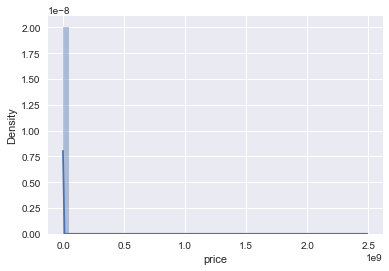

In [57]:
sns_plot = sns.distplot(df['price'])
fig = sns_plot.get_figure()

In [58]:
df['price'].describe()

count    1.883420e+05
mean     2.855857e+04
std      5.745793e+06
min      1.000000e+00
25%      6.400000e+03
50%      1.150000e+04
75%      1.928500e+04
max      2.490531e+09
Name: price, dtype: float64

Какой-то ужас, максимальная цена 2.5 миллиарда

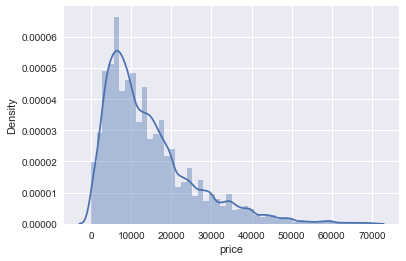

In [59]:
sns_plot = sns.distplot(df['price'][df['price']<70000])
fig = sns_plot.get_figure()

Удаляем выбросы

In [6]:
df = df[df['price']<70000]

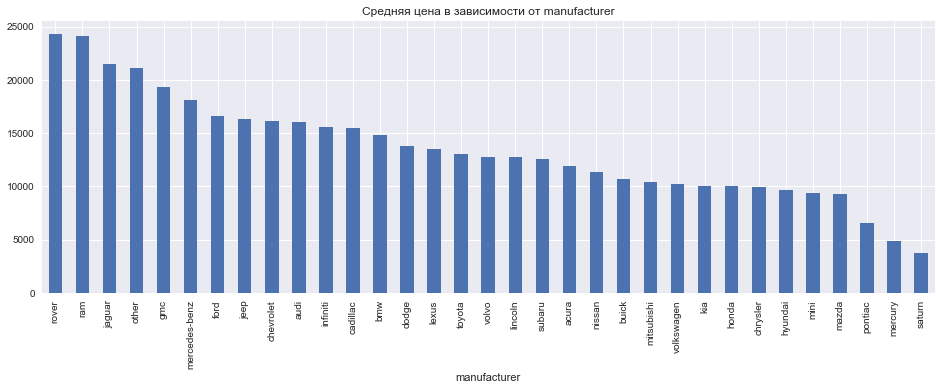

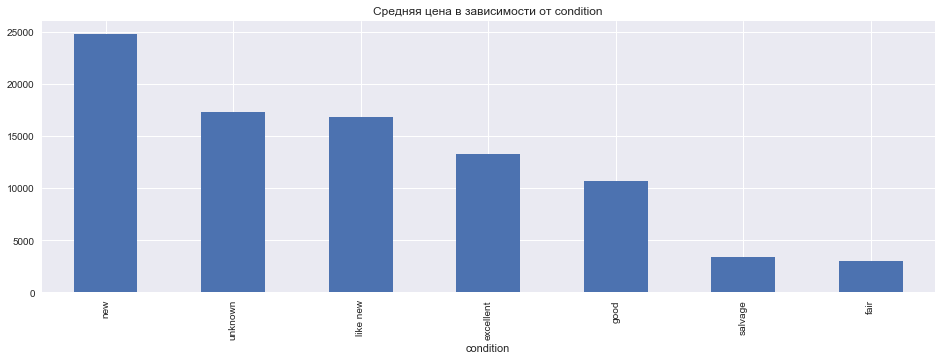

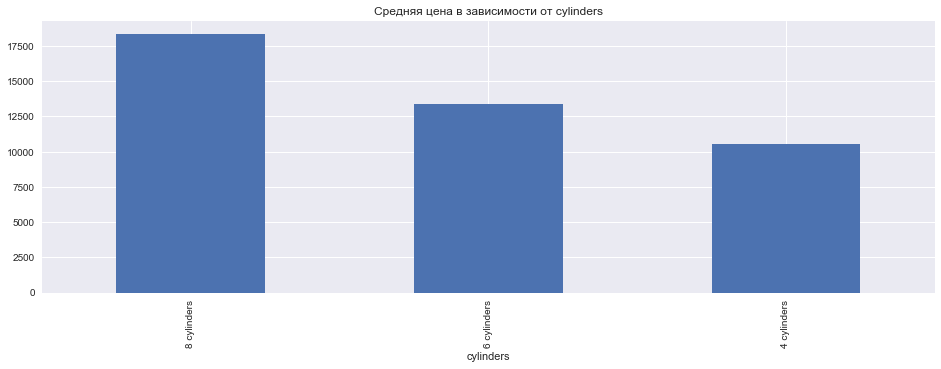

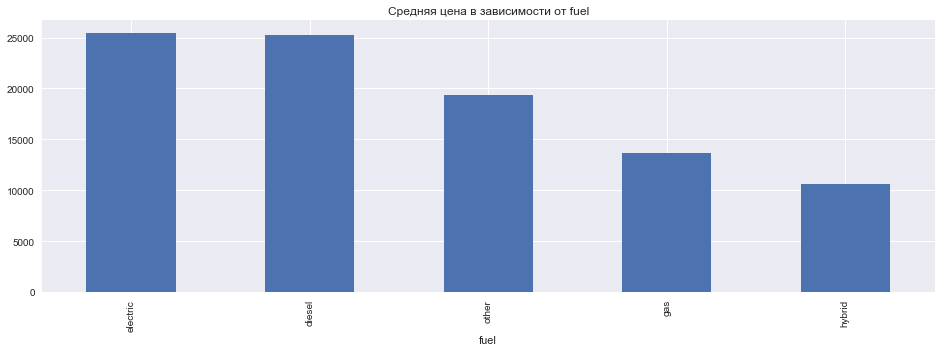

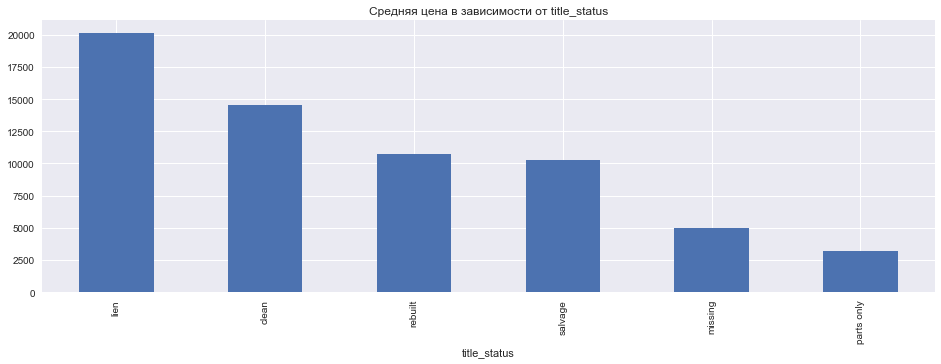

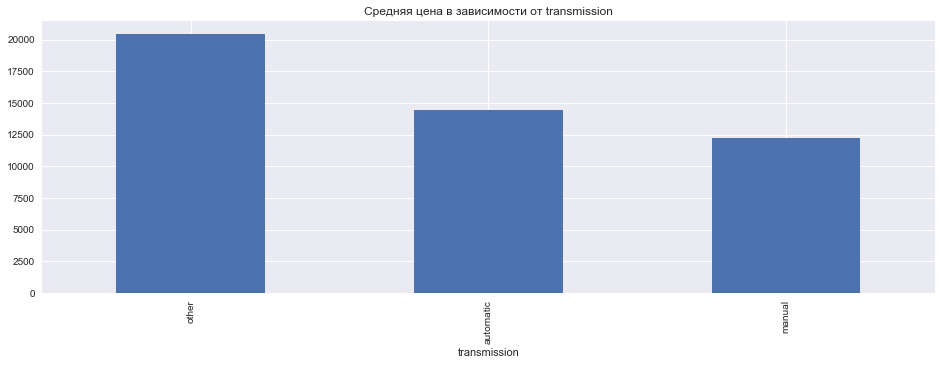

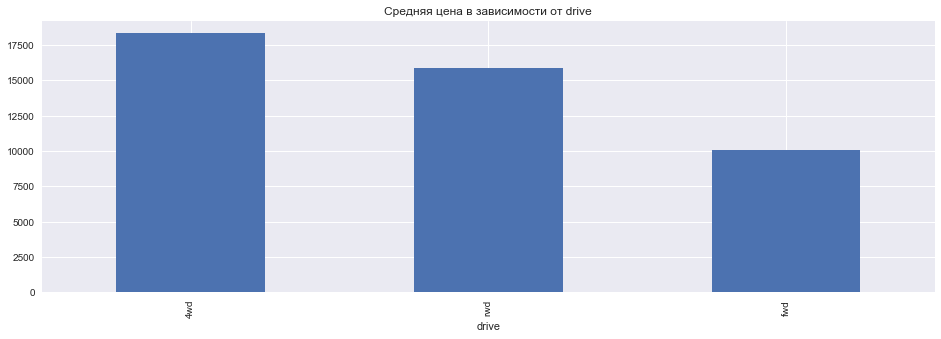

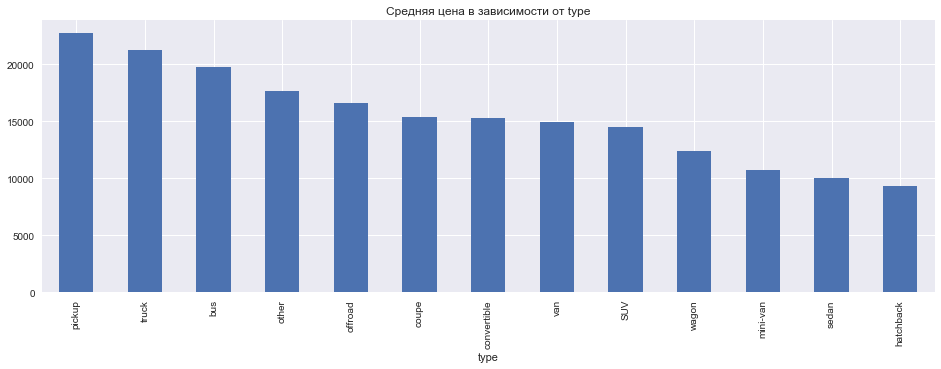

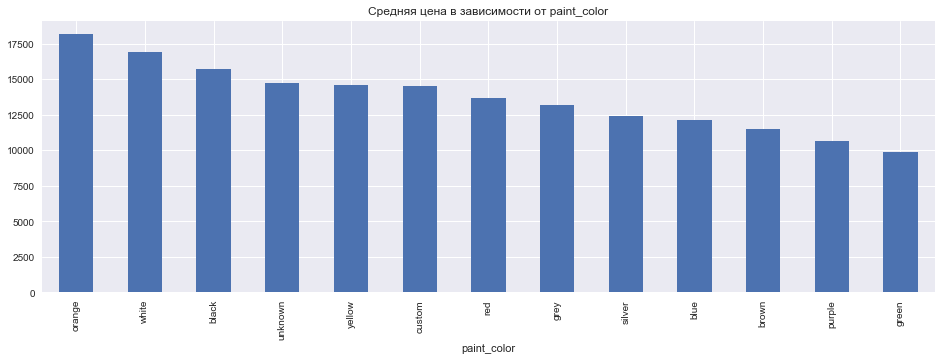

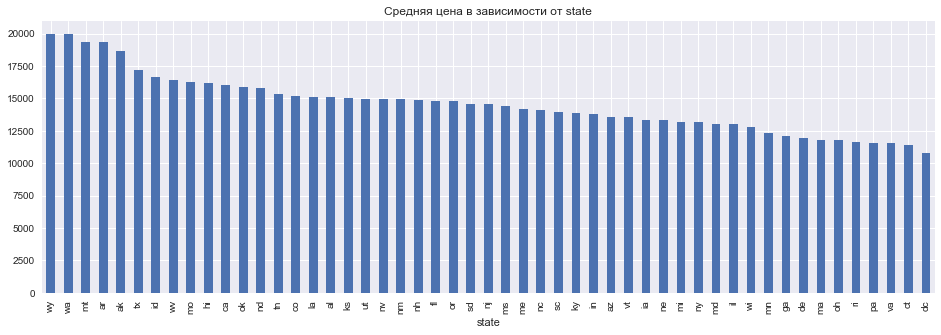

In [61]:
for i in ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status',
        'transmission', 'drive', 'type', 'paint_color', 'state']:
    df.groupby(i)["price"].mean().sort_values(ascending=False).plot.bar(figsize=(16,5));
    plt.title('Средняя цена в зависимости от ' + i)
    plt.show();

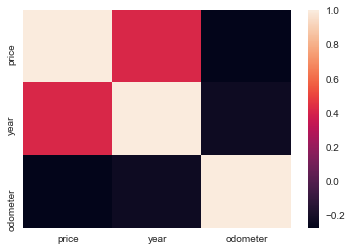

In [29]:
sns.heatmap(df.corr())

In [63]:
df[df['transmission']=='other']

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
35,3,19995,2005,ford,excellent,8 cylinders,diesel,167828,clean,other,4wd,full-size,truck,unknown,nm
131,2,12970,2014,chevrolet,good,8 cylinders,gas,198334,clean,other,4wd,mid-size,van,white,mn
150,2,7495,2013,toyota,excellent,4 cylinders,hybrid,179000,clean,other,fwd,compact,hatchback,green,mn
463,2,10995,2014,chevrolet,good,NaN,gas,138154,clean,other,fwd,full-size,SUV,grey,mn
470,3,18980,1999,chevrolet,unknown,8 cylinders,gas,38437,clean,other,rwd,mid-size,hatchback,custom,nm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187737,1,11950,2014,mazda,excellent,4 cylinders,gas,81914,clean,other,fwd,mid-size,hatchback,silver,va
188058,4,8995,2015,chrysler,good,4 cylinders,gas,104480,clean,other,fwd,mid-size,sedan,grey,nj
188074,2,10990,2012,honda,good,NaN,gas,62472,clean,other,fwd,compact,sedan,silver,ct
188096,2,27990,2019,ford,good,NaN,gas,1683,clean,other,rwd,compact,coupe,blue,ct


In [64]:
df['transmission'].value_counts()

automatic    172937
manual        11029
other          3975
Name: transmission, dtype: int64

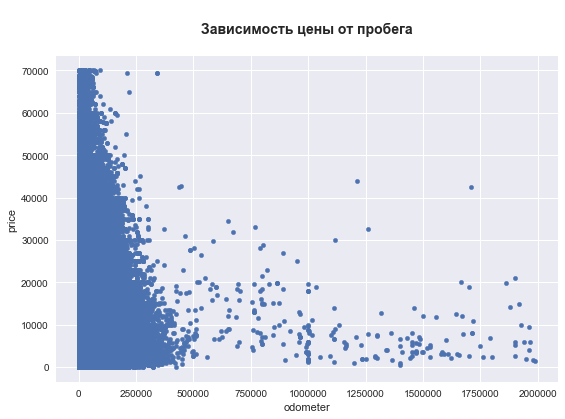

In [65]:
df[df['odometer']<2000000].plot.scatter(x='odometer', y='price', figsize=(9,6),)
plt.title('\nЗависимость цены от пробега\n', fontsize=14, fontweight='bold');

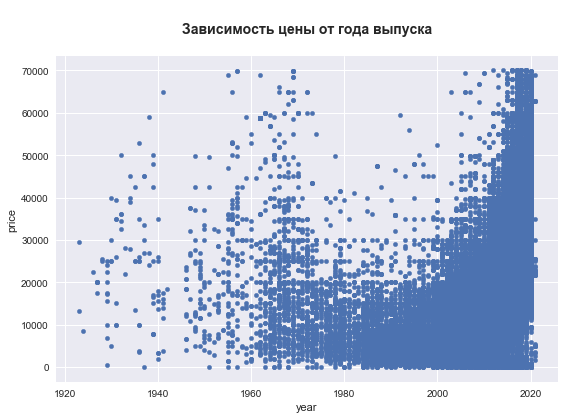

In [66]:
df.plot.scatter(x='year', y='price', figsize=(9,6),)
plt.title('\nЗависимость цены от года выпуска\n', fontsize=14, fontweight='bold');

In [31]:
df.head()

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,1,8750,2013,hyundai,excellent,4 cylinders,gas,90821,clean,automatic,fwd,full-size,sedan,grey,mn
1,2,10900,2013,toyota,good,4 cylinders,hybrid,92800,clean,automatic,fwd,mid-size,hatchback,blue,ct
2,1,16995,2007,gmc,good,8 cylinders,diesel,254217,clean,automatic,4wd,full-size,truck,white,mn
3,1,13995,2012,ford,good,6 cylinders,gas,188406,clean,automatic,4wd,full-size,truck,grey,mn
4,1,7995,2010,chevrolet,good,4 cylinders,gas,108124,clean,automatic,4wd,full-size,SUV,grey,mn


In [32]:
df.isna().sum()

region              0
price               0
year                0
manufacturer        0
condition           0
cylinders       58848
fuel                0
odometer            0
title_status        0
transmission        0
drive               0
size                0
type                0
paint_color         0
state               0
dtype: int64

Заполняю пропущенные значения цилиндров с помощью модели

Делаю все категориальные переменные, кроме цилиндров дамми-переменными

In [8]:
cat_feats = df.drop(columns=['cylinders']).select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [9]:
df_cyl = pd.concat([df[['price', 'year','cylinders','odometer']], cat_feats], axis=1)
df_cyl.head()

,price,year,cylinders,odometer,region_1,region_2,region_3,region_4,manufacturer_acura,manufacturer_audi,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
0,8750,2013,4 cylinders,90821,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10900,2013,4 cylinders,92800,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16995,2007,8 cylinders,254217,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13995,2012,6 cylinders,188406,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7995,2010,4 cylinders,108124,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_cyl.dtypes

price           int64
year            int64
cylinders    category
odometer        int64
region_1        uint8
               ...   
state_vt        uint8
state_wa        uint8
state_wi        uint8
state_wv        uint8
state_wy        uint8
Length: 146, dtype: object

Пробую модель Random Forest

In [36]:
train_data = df_cyl[df_cyl['cylinders'].notnull()]
test_data  = df_cyl[df_cyl['cylinders'].isnull()]

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(
    train_data.drop(['price', 'cylinders'], axis=1), train_data['cylinders'], test_size=0.3, random_state=18)

In [76]:
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)
print(clf.score(X_train, Y_train))
print(clf.score(X_test, Y_test))

0.9920323133956731
0.8607983887626524


Присутствует переобучение, пробую Grid search.

In [81]:
clf = RandomForestClassifier()
param_grid = { 
    'n_estimators': [500, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,15,20],
}
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 3, n_jobs=-1, verbose=True)
CV_rfc.fit(X_train, Y_train)
CV_rfc.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 10.3min finished


{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 700}

In [85]:
print(f'Точность на тренировочной выборке: {CV_rfc.score(X_train, Y_train)}')
print(f'Точность на тестовой выборке: {CV_rfc.score(X_test, Y_test)}')

Точность на тренировочной выборке: 0.8870469761522713
Точность на тестовой выборке: 0.8423104730427597


Вполне приемлимая точность, обучаю модель на всех имеющихся данных и заполняю отсутствующие значения

In [38]:
clf = RandomForestClassifier(n_estimators= 700, max_features= 'sqrt', max_depth= 20)
clf.fit(train_data.drop(['cylinders', 'price'], axis=1), train_data['cylinders'])
predicted_cyl = clf.predict(test_data.drop(columns=['cylinders', 'price']))

In [39]:
predicted_cyl = pd.DataFrame(predicted_cyl)
predicted_cyl.columns = ['cylinders']
predicted_cyl

,cylinders
0,8 cylinders
1,8 cylinders
2,8 cylinders
3,6 cylinders
4,4 cylinders
...,...
58843,8 cylinders
58844,8 cylinders
58845,6 cylinders
58846,6 cylinders


In [40]:
cyl_filled = pd.concat([test_data.drop('cylinders', axis=1).reset_index(), predicted_cyl], axis=1).drop('index', axis=1)

In [41]:
cyl_filled

,price,year,odometer,region_1,region_2,region_3,region_4,manufacturer_acura,manufacturer_audi,manufacturer_bmw,...,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,cylinders
0,10995,2008,143528,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8 cylinders
1,6000,1997,152415,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8 cylinders
2,7500,2009,271000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8 cylinders
3,28990,2019,23772,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6 cylinders
4,12995,2013,116711,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4 cylinders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58843,30000,1970,53325,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8 cylinders
58844,6000,1994,37000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8 cylinders
58845,27990,2019,32700,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6 cylinders
58846,4990,2007,131867,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6 cylinders


In [42]:
df_clear = pd.concat([train_data, cyl_filled], ignore_index = True)

In [43]:
df_clear

,price,year,cylinders,odometer,region_1,region_2,region_3,region_4,manufacturer_acura,manufacturer_audi,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
0,8750,2013,4 cylinders,90821,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10900,2013,4 cylinders,92800,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16995,2007,8 cylinders,254217,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13995,2012,6 cylinders,188406,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7995,2010,4 cylinders,108124,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187936,30000,1970,8 cylinders,53325,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187937,6000,1994,8 cylinders,37000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187938,27990,2019,6 cylinders,32700,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187939,4990,2007,6 cylinders,131867,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Готово, проверяю, что действительно нет отсутствующих значений

In [44]:
df_clear['cylinders'].value_counts(dropna = False)

4 cylinders    75302
6 cylinders    65804
8 cylinders    46835
Name: cylinders, dtype: int64

Делаю цилиндры дамми переменной

In [45]:
cylinders = df_clear['cylinders']
cylinders = pd.get_dummies(cylinders)

In [46]:
df_clear = pd.concat([df_clear.drop('cylinders', axis=1), cylinders], axis=1)

In [47]:
df_clear

,price,year,odometer,region_1,region_2,region_3,region_4,manufacturer_acura,manufacturer_audi,manufacturer_bmw,...,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,4 cylinders,6 cylinders,8 cylinders
0,8750,2013,90821,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,10900,2013,92800,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,16995,2007,254217,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,13995,2012,188406,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,7995,2010,108124,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187936,30000,1970,53325,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
187937,6000,1994,37000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
187938,27990,2019,32700,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
187939,4990,2007,131867,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [48]:
df_clear.to_csv('vehicles_superclear.csv')

In [3]:
df_clear = pd.read_csv('vehicles_superclear.csv').drop(columns=['Unnamed: 0'])

In [4]:
for col in df_clear.drop(columns=['price','year','odometer']).columns:
    df_clear[col] = df_clear[col].astype('uint8')

In [5]:
df_clear.dtypes

price          int64
year           int64
odometer       int64
region_1       uint8
region_2       uint8
               ...  
state_wv       uint8
state_wy       uint8
4 cylinders    uint8
6 cylinders    uint8
8 cylinders    uint8
Length: 148, dtype: object

## Приступаю к обучению моделей

Выделяю целевую переменную и разбиваю данные на тестовые и обучающие

In [6]:
target = df_clear[['price']]

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(df_clear.drop(columns=['price']), target, test_size=0.2, random_state=18)

Буду строить модель на XGBoost

In [8]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [9]:
booster = xgb.XGBRegressor()

Нахожу лучшие параметры через Grid Search

In [ ]:
param_grid = {'n_estimators': [150, 200, 250],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [6, 10, 15, 18],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.25]}

booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1, verbose=True)

booster_grid_search.fit(X_train, Y_train)

print(booster_grid_search.best_params_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  7.9min


Видимо, в модели слишком много данных, мой компьютер отказывается это обрабатывать.  
В голову приходят 2 пути решения:  
1) Воспользоваться методом главных компонент, тем самым уменьшить количество параметров

Подбираю оптимальное количество компонент

In [10]:
for i in range(7, 26):
    pca = PCA(n_components=i)
    new_features = StandardScaler().fit_transform(df_clear.drop(columns=['price']))
    new_features = pca.fit_transform(new_features)
    
    X_train, X_test, Y_train, Y_test = train_test_split(new_features, target, test_size=0.2)
    
    booster = xgb.XGBRegressor()
    booster.fit(X_train, Y_train)
    predict_price = booster.predict(X_test)

    print(i, " компонент")
    print("Точность на трэйновой выборке: ", booster.score(X_train, Y_train))
    print("Точность на тестовой выборке: ", booster.score(X_test, Y_test))
    print("mean_absolute_error: ", mean_absolute_error(Y_test, predict_price))
    print("mean_squared_error: ", np.sqrt(mean_squared_error(Y_test, predict_price)))
    print('')

7  компонент
Точность на трэйновой выборке:  0.5851073187651277
Точность на тестовой выборке:  0.5275562194295289
mean_absolute_error:  5533.668400010969
mean_squared_error:  7736.072340699926

8  компонент
Точность на трэйновой выборке:  0.6227821968524432
Точность на тестовой выборке:  0.553495508147881
mean_absolute_error:  5298.600300094117
mean_squared_error:  7434.978898251188

9  компонент
Точность на трэйновой выборке:  0.6503668140417529
Точность на тестовой выборке:  0.5822551316782582
mean_absolute_error:  5128.617323001621
mean_squared_error:  7208.693971269176

10  компонент
Точность на трэйновой выборке:  0.6516071980303317
Точность на тестовой выборке:  0.5928163234574284
mean_absolute_error:  5075.560492549891
mean_squared_error:  7134.104902617437

11  компонент
Точность на трэйновой выборке:  0.6695338525692307
Точность на тестовой выборке:  0.5999914250086242
mean_absolute_error:  5006.5341263626215
mean_squared_error:  7079.7443521256155

12  компонент
Точность на т

PCA с 24 компонентами показал себя лучше всего, однако с таком количеством все равно не отрабатывает grid search. 12 компонент тоже показывают приемлимый результат, пробую с ним.

In [11]:
pca = PCA(n_components=12)
new_features = StandardScaler().fit_transform(df_clear.drop(columns=['price']))
new_features = pca.fit_transform(new_features)
    
X_train, X_test, Y_train, Y_test = train_test_split(new_features, target, test_size=0.33)

booster = xgb.XGBRegressor()

param_grid = {'n_estimators': [150, 250],
              'learning_rate': [0.05, 0.1], 
              'max_depth': [6, 10, 12],
              'colsample_bytree': [0.6, 1],
              'gamma': [0.0, 0.1, 0.22]}

booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1, verbose=True)

booster_grid_search.fit(X_train, Y_train)

print(booster_grid_search.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.8min


KeyboardInterrupt: 

{'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 250}

In [63]:
pca = PCA(n_components=12)
new_features = StandardScaler().fit_transform(df_clear.drop(columns=['price']))
new_features = pca.fit_transform(new_features)
    
X_train, X_test, Y_train, Y_test = train_test_split(new_features, target, test_size=0.2)

booster = xgb.XGBRegressor(colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=12, n_estimators=250)

booster.fit(X_train, Y_train)
predict_price = booster.predict(X_test)

print("Точность на трэйновой выборке: ", booster.score(X_train, Y_train))
print("Точность на тестовой выборке: ", booster.score(X_test, Y_test))
print("mean_absolute_error: ", mean_absolute_error(Y_test, predict_price))
print("mean_squared_error: ", np.sqrt(mean_squared_error(Y_test, predict_price)))

Точность на трэйновой выборке:  0.9396673608449365
Точность на тестовой выборке:  0.7351472353549493
mean_absolute_error:  3704.3679602795523
mean_squared_error:  5752.257090210109


Видно, что модель переобучена, но особых идей как это исправлять у меня нет. Пробую второй вариант.

2) Подобрать оптимальные параметры на меньшей выборке, обучить модель на них, а затем уменьшить количество параметров

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_clear.drop(columns=['price']).loc[0:30000], target.loc[0:30000], test_size=0.2, random_state=18)

In [22]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [23]:
booster = xgb.XGBRegressor()

In [24]:
param_grid = {'n_estimators': [150, 200, 250],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [6, 10, 15, 18],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.25]}

booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1, verbose=True)

booster_grid_search.fit(X_train, Y_train)

print(booster_grid_search.best_params_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 59.2min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 79.3min finished


{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 250}


{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 250}

Обучаю модель

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_clear.drop(columns=['price']), target, test_size=0.2, random_state=18)

In [8]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [9]:
booster = xgb.XGBRegressor(colsample_bytree=0.6 , gamma=0.0 , learning_rate=0.1 , 
                           max_depth=10 , n_estimators=250 )

booster.fit(X_train, Y_train)

y_pred_test = booster.predict(X_test)

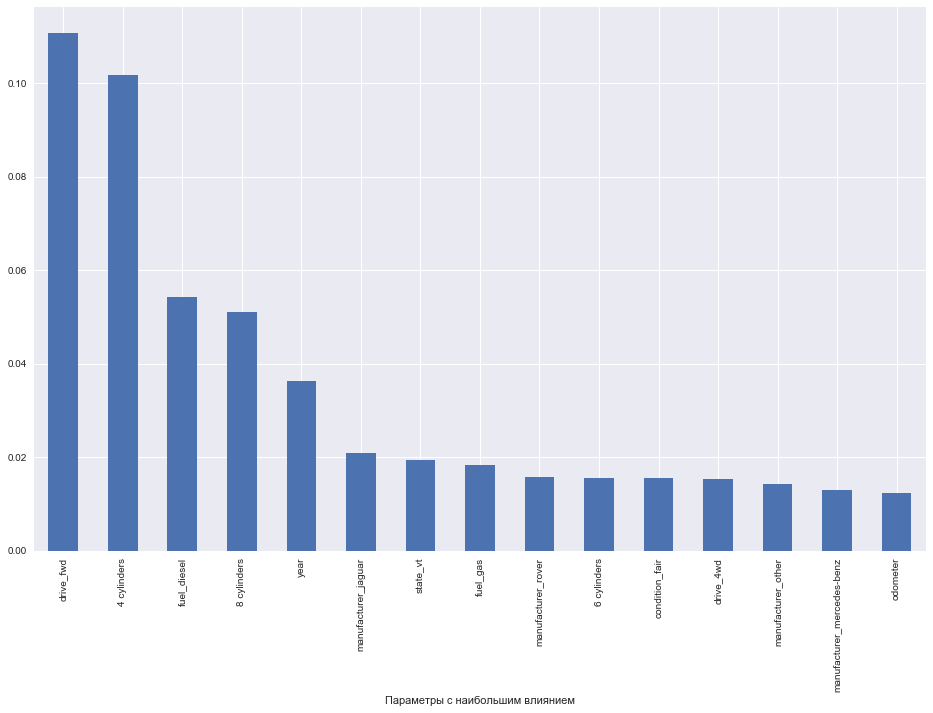

In [10]:
feat_importances = pd.Series(booster.feature_importances_, index=df_clear.drop(columns=['price']).columns)
feat_importances.nlargest(15).sort_values(ascending=False).plot.bar(figsize=(16,10))
plt.xlabel('Параметры с наибольшим влиянием');

In [70]:
len(df_clear.drop(columns=['price']).columns)

147

In [73]:
max_accuracy = 0
for i in range(5,148):
    X_train, X_test, Y_train, Y_test = train_test_split(
        df_clear.drop(columns=['price'])[feat_importances.nlargest(i).sort_values().keys()], target, test_size=0.2)
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test  = sc.transform(X_test)
    
    booster = xgb.XGBRegressor(colsample_bytree=0.6 , gamma=0.0 , learning_rate=0.1 , 
                           max_depth=10 , n_estimators=250)
    booster.fit(X_train, Y_train)
    predict_price = booster.predict(X_test)
    
    if (booster.score(X_test, Y_test) > max_accuracy):
        best_parameters_count = i
        max_accuracy = booster.score(X_test, Y_test)
        max_train_accuracy = booster.score(X_train, Y_train)
        best_mean_absolute_error = mean_absolute_error(Y_test, predict_price)
        best_mean_squared_error = np.sqrt(mean_squared_error(Y_test, predict_price))
        
    print(i, ' параметров')
    print('Точность на трэйновом множестве: ', booster.score(X_train, Y_train))
    print('Точность на тестовом множестве: ', booster.score(X_test, Y_test))
    print('mean_absolute_error : ', mean_absolute_error(Y_test, predict_price))
    print('mean_squared_error : ', np.sqrt(mean_squared_error(Y_test, predict_price)))
    print('')
    
print(f'Максимальная точность на тестовом подмножестве при {best_parameters_count} параметрах.')
print('Точность на трэйновом множестве: ', max_train_accuracy)
print('Точность на тестовом множестве: ', max_accuracy)
print('mean_absolute_error : ', best_mean_absolute_error)
print('mean_squared_error : ', best_mean_squared_error)

5  параметров
Точность на трэйновом множестве:  0.6932466353746163
Точность на тестовом множестве:  0.6878839832724101
mean_absolute_error :  4059.1108998770524
mean_squared_error :  6180.741930252315

6  параметров
Точность на трэйновом множестве:  0.6942805210826937
Точность на тестовом множестве:  0.6926321425947783
mean_absolute_error :  4069.8451956640097
mean_squared_error :  6222.320793304205

7  параметров
Точность на трэйновом множестве:  0.7005869033412262
Точность на тестовом множестве:  0.6838727638410478
mean_absolute_error :  4078.0885864540346
mean_squared_error :  6252.9054064889415

8  параметров
Точность на трэйновом множестве:  0.7012677877212403
Точность на тестовом множестве:  0.6895244346353894
mean_absolute_error :  4068.483585139576
mean_squared_error :  6228.465167778143

9  параметров
Точность на трэйновом множестве:  0.7027020582800081
Точность на тестовом множестве:  0.6955615884042131
mean_absolute_error :  4006.0126488505043
mean_squared_error :  6130.7251

46  параметров
Точность на трэйновом множестве:  0.8949394679548445
Точность на тестовом множестве:  0.8525757125364855
mean_absolute_error :  2637.7507303488023
mean_squared_error :  4299.757894646252

47  параметров
Точность на трэйновом множестве:  0.8986344889586336
Точность на тестовом множестве:  0.8533204558727161
mean_absolute_error :  2602.435418531378
mean_squared_error :  4284.7140905837405

48  параметров
Точность на трэйновом множестве:  0.9012188360306278
Точность на тестовом множестве:  0.8570997205790707
mean_absolute_error :  2572.0339076454634
mean_squared_error :  4188.032369475784

49  параметров
Точность на трэйновом множестве:  0.9007903100517516
Точность на тестовом множестве:  0.8513557591730337
mean_absolute_error :  2608.885518635219
mean_squared_error :  4284.477130172981

50  параметров
Точность на трэйновом множестве:  0.901104636024795
Точность на тестовом множестве:  0.854047773604397
mean_absolute_error :  2589.263282768369
mean_squared_error :  4253.414

87  параметров
Точность на трэйновом множестве:  0.9244602233577252
Точность на тестовом множестве:  0.879293084396962
mean_absolute_error :  2308.3985922046018
mean_squared_error :  3847.7745965017825

88  параметров
Точность на трэйновом множестве:  0.9272853243200068
Точность на тестовом множестве:  0.8759305371452626
mean_absolute_error :  2328.5036533970406
mean_squared_error :  3936.814773379057

89  параметров
Точность на трэйновом множестве:  0.9264731862848474
Точность на тестовом множестве:  0.8787717275573501
mean_absolute_error :  2334.8228561614283
mean_squared_error :  3922.378028324594

90  параметров
Точность на трэйновом множестве:  0.9249909724383132
Точность на тестовом множестве:  0.8826225946732384
mean_absolute_error :  2292.0446737195507
mean_squared_error :  3823.8807078744903

91  параметров
Точность на трэйновом множестве:  0.9280789503580843
Точность на тестовом множестве:  0.8830033744064236
mean_absolute_error :  2295.6468953721214
mean_squared_error :  386

Точность на тестовом множестве:  0.8865057113243779
mean_absolute_error :  2259.583224513252
mean_squared_error :  3786.879611880721

128  параметров
Точность на трэйновом множестве:  0.9299700332837577
Точность на тестовом множестве:  0.8802591926722866
mean_absolute_error :  2306.2695250716297
mean_squared_error :  3885.972196725724

129  параметров
Точность на трэйновом множестве:  0.9310672189588248
Точность на тестовом множестве:  0.8822024492589644
mean_absolute_error :  2296.6866921493215
mean_squared_error :  3824.7303258670636

130  параметров
Точность на трэйновом множестве:  0.9303114209896262
Точность на тестовом множестве:  0.8766569489050116
mean_absolute_error :  2310.5383091655385
mean_squared_error :  3903.770960536053

131  параметров
Точность на трэйновом множестве:  0.9295257365142717
Точность на тестовом множестве:  0.8803777859585422
mean_absolute_error :  2301.9777217846113
mean_squared_error :  3846.9708528885103

132  параметров
Точность на трэйновом множестве:

Точность хорошая, но довольно большое квадратичное отклонение. Возможно, модель ошибается на больштх ценах, попробую ограничить максимальную цену.

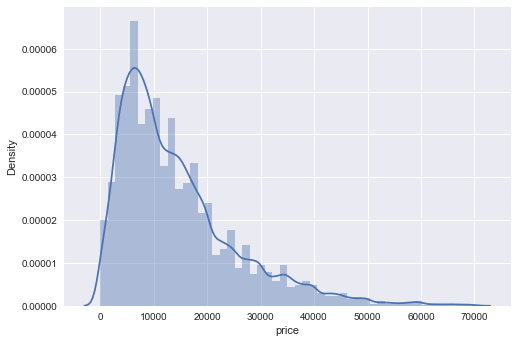

In [58]:
sns_plot = sns.distplot(df_clear['price'])
fig = sns_plot.get_figure()

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(
        df_clear[df_clear['price']<36000].drop(columns=['price']), df_clear[df_clear['price']<36000]['price'], test_size=0.2)
    
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)
    
booster = xgb.XGBRegressor()
booster.fit(X_train, Y_train)
predict_price = booster.predict(X_test)

print("Точность на трэйновом множестве: ", booster.score(X_train, Y_train))
print("Точность на тестовом множестве: ", booster.score(X_test, Y_test))
print("mean_absolute_error : ", mean_absolute_error(Y_test, predict_price))
print("mean_squared_error : ", np.sqrt(mean_squared_error(Y_test, predict_price)))

Точность на трэйновом множестве:  0.8437503661927872
Точность на тестовом множестве:  0.8170169612170475
mean_absolute_error :  2322.214096485858
mean_squared_error :  3587.404711256864


Ошибка чуть меньше, подбираю лучшие параметры.

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_clear[df_clear['price']<36000].drop(columns=['price']).loc[0:30000], 
    df_clear[df_clear['price']<36000]['price'].loc[0:30000], 
    test_size=0.2, random_state=18)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

booster = xgb.XGBRegressor()

param_grid = {'n_estimators': [150, 250],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [6, 10, 15, 18],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.25]}

booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1, verbose=True)

booster_grid_search.fit(X_train, Y_train)

print(booster_grid_search.best_params_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 51.2min finished


{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 250}


Обучаю модель на всех данных

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(
        df_clear[df_clear['price']<36000].drop(columns=['price']),
        df_clear[df_clear['price']<36000]['price'], test_size=0.2)
    
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)
    
booster = xgb.XGBRegressor(colsample_bytree=0.6 , gamma=0.0 , learning_rate=0.1 , 
                           max_depth=10 , n_estimators=250)
booster.fit(X_train, Y_train)
predict_price = booster.predict(X_test)

print("Точность на трэйновом множестве: ", booster.score(X_train, Y_train))
print("Точность на тестовом множестве: ", booster.score(X_test, Y_test))
print("mean_absolute_error : ", mean_absolute_error(Y_test, predict_price))
print("mean_squared_error : ", np.sqrt(mean_squared_error(Y_test, predict_price)))

Точность на трэйновом множестве:  0.9147633773639167
Точность на тестовом множестве:  0.8659915084858096
mean_absolute_error :  1957.2758687776136
mean_squared_error :  3068.389759925398


При сравнимой точности среднее квадратичное отклонение уменьшилась, такая модель будет лучше предсказывать цену автомобилей среднего ценового сегмента.

Добавляю еще несколько моделек специально для Вас, Михаил Викторович!

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df_clear.drop(columns=['price']), target, test_size=0.2, random_state=18)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import time

Самая обычная линейная регрессия

In [15]:
start_time = time.time()
reg = LinearRegression().fit(X_train, Y_train)
predict_price = reg.predict(X_test)

print("Точность на трэйновом множестве: ", reg.score(X_train, Y_train))
print("Точность на тестовом множестве: ", reg.score(X_test, Y_test))
print("mean_absolute_error : ", mean_absolute_error(Y_test, predict_price))
print("mean_squared_error : ", np.sqrt(mean_squared_error(Y_test, predict_price)))
print("--- %s seconds ---" % (time.time() - start_time))

Точность на трэйновом множестве:  0.5148278671339279
Точность на тестовом множестве:  0.4914067149637669
mean_absolute_error :  5181.610850741115
mean_squared_error :  7974.486898837638
--- 2.902677059173584 seconds ---


SGD- Стохактический градиентный спуск

In [16]:
start_time = time.time()
reg = SGDRegressor().fit(X_train, Y_train)
predict_price = reg.predict(X_test)

print("Точность на трэйновом множестве: ", reg.score(X_train, Y_train))
print("Точность на тестовом множестве: ", reg.score(X_test, Y_test))
print("mean_absolute_error : ", mean_absolute_error(Y_test, predict_price))
print("mean_squared_error : ", np.sqrt(mean_squared_error(Y_test, predict_price)))
print("--- %s seconds ---" % (time.time() - start_time))

Точность на трэйновом множестве:  -9.821080504508103e+28
Точность на тестовом множестве:  -1.4251927734009624e+29
mean_absolute_error :  2.395114180156049e+18
mean_squared_error :  4.221378012267723e+18
--- 3.7765450477600098 seconds ---


Эластик нет- смесь лассо и ридж регрессии

In [17]:
start_time = time.time()
reg = ElasticNet().fit(X_train, Y_train)
predict_price = reg.predict(X_test)

print("Точность на трэйновом множестве: ", reg.score(X_train, Y_train))
print("Точность на тестовом множестве: ", reg.score(X_test, Y_test))
print("mean_absolute_error : ", mean_absolute_error(Y_test, predict_price))
print("mean_squared_error : ", np.sqrt(mean_squared_error(Y_test, predict_price)))
print("--- %s seconds ---" % (time.time() - start_time))

Точность на трэйновом множестве:  0.4148550599006643
Точность на тестовом множестве:  0.3854463338911649
mean_absolute_error :  5771.794969357406
mean_squared_error :  8765.916810616787
--- 1.1641991138458252 seconds ---


Лассо регрессия (метод регуляризации- лассо)

In [18]:
start_time = time.time()
reg = Lasso().fit(X_train, Y_train)
predict_price = reg.predict(X_test)

print("Точность на трэйновом множестве: ", reg.score(X_train, Y_train))
print("Точность на тестовом множестве: ", reg.score(X_test, Y_test))
print("mean_absolute_error : ", mean_absolute_error(Y_test, predict_price))
print("mean_squared_error : ", np.sqrt(mean_squared_error(Y_test, predict_price)))
print("--- %s seconds ---" % (time.time() - start_time))

Точность на трэйновом множестве:  0.5146891755937261
Точность на тестовом множестве:  0.4911380769892139
mean_absolute_error :  5177.23028647237
mean_squared_error :  7976.592674968829
--- 41.64660954475403 seconds ---


Ридж регрессия (метод регуляризации- ридж)

In [19]:
start_time = time.time()
reg = Ridge().fit(X_train, Y_train)
predict_price = reg.predict(X_test)

print("Точность на трэйновом множестве: ", reg.score(X_train, Y_train))
print("Точность на тестовом множестве: ", reg.score(X_test, Y_test))
print("mean_absolute_error : ", mean_absolute_error(Y_test, predict_price))
print("mean_squared_error : ", np.sqrt(mean_squared_error(Y_test, predict_price)))
print("--- %s seconds ---" % (time.time() - start_time))

Точность на трэйновом множестве:  0.5148278128957884
Точность на тестовом множестве:  0.49140449870332253
mean_absolute_error :  5181.542051777846
mean_squared_error :  7974.50427374323
--- 0.7496137619018555 seconds ---


Градиентный буст регрессии (Ранее был буст случайного леса)

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

start_time = time.time()
reg = GradientBoostingRegressor().fit(X_train, Y_train)
predict_price = reg.predict(X_test)

print("Точность на трэйновом множестве: ", reg.score(X_train, Y_train))
print("Точность на тестовом множестве: ", reg.score(X_test, Y_test))
print("mean_absolute_error : ", mean_absolute_error(Y_test, predict_price))
print("mean_squared_error : ", np.sqrt(mean_squared_error(Y_test, predict_price)))
print("--- %s seconds ---" % (time.time() - start_time))

Точность на трэйновом множестве:  0.7707396749334084
Точность на тестовом множестве:  0.7714171712878217
mean_absolute_error :  3358.237406111177
mean_squared_error :  5346.1266050532395
--- 63.225276947021484 seconds ---


Support Vector Regression

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

start_time = time.time()

reg = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
reg.fit(X_train, Y_train)
predict_price = reg.predict(X_test)

print("Точность на трэйновом множестве: ", reg.score(X_train, Y_train))
print("Точность на тестовом множестве: ", reg.score(X_test, Y_test))
print("mean_absolute_error : ", mean_absolute_error(Y_test, predict_price))
print("mean_squared_error : ", np.sqrt(mean_squared_error(Y_test, predict_price)))
print("--- %s seconds ---" % (time.time() - start_time))

SVR так и не дообучился, ждать не стал, остановил.

Что касается выводов- градиентный бустинг- лучшее, что могло случиться с человечеством. Все остальные модели регрессии, хоть и без гиперпараметров, но все же ОЧЕНЬ сильно остают от буста. Но обучаются быстро. Например, Ридж регрессия- обучается менее секунды, что вполне позволяет использовать ее в качестве своего рода "предпросмотра" данных.